In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, ViTModel
from PIL import Image
import pandas as pd
import torchvision.transforms as transforms
from tqdm import tqdm  # Import tqdm for progress bars

# --- Dataset and Preprocessing ---

class CrisisDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_transform):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # Tokenize tweet text (using a max length of 128 tokens)
        encoding = self.tokenizer(
            row['tweet_text'],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()       # (max_length,)
        attention_mask = encoding['attention_mask'].squeeze()  # (max_length,)

        # Load image (assuming the path stored in the dataframe is valid)
        image_path = row['image']
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        # Convert string labels to binary (1 for "informative", 0 for "not_informative")
        label = 1.0 if row['label'] == "informative" else 0.0
        label_text = 1.0 if row['label_text'] == "informative" else 0.0
        label_image = 1.0 if row['label_image'] == "informative" else 0.0

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'label': torch.tensor(label, dtype=torch.float),
            'label_text': torch.tensor(label_text, dtype=torch.float),
            'label_image': torch.tensor(label_image, dtype=torch.float)
        }

# Define image transformations for ViT (resize, normalization, etc.)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Example normalization; adjust mean and std as needed for your pretrained ViT model
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load your CSV/TSV files (adjust file paths as needed)
train_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', sep='\t')
dev_df = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv', sep='\t')

# Create dataset and dataloaders
train_dataset = CrisisDataset(train_df, tokenizer, image_transform)
dev_dataset = CrisisDataset(dev_df, tokenizer, image_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False)

# --- Model Definition with Gated Fusion for Multimodal Branch ---

class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()
        # Load pretrained encoders for text and image.
        self.text_encoder = BertModel.from_pretrained('bert-base-uncased')
        # Use a pretrained ViT; note that "google/vit-base-patch16-224-in21k" outputs 768-dim embeddings.
        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        
        # Both models output embeddings of size 768 so that they share a common space.
        hidden_size = self.text_encoder.config.hidden_size
        
        self.dropout = nn.Dropout(0.1)
        # --- Multimodal branch using gated fusion ---
        # Gating layer: takes the sum of text and image embeddings and outputs gate values.
        self.gate_layer = nn.Linear(hidden_size, hidden_size)
        # Classifier on the fused representation.
        self.classifier = nn.Linear(hidden_size, 1)
        
        # --- Individual modality heads ---
        # Text-only head (hidden_size input)
        self.text_head = nn.Linear(hidden_size, 1)
        # Image-only head (hidden_size input)
        self.image_head = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, image):
        # Text encoding
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.pooler_output  # shape: (batch, hidden_size)
        
        # Image encoding
        image_outputs = self.image_encoder(pixel_values=image)
        image_embeds = image_outputs.pooler_output  # shape: (batch, hidden_size)
        
        # --- Gated fusion for multimodal representation ---
        gate = torch.sigmoid(self.gate_layer(text_embeds + image_embeds))  # (batch, hidden_size)
        fused = gate * text_embeds + (1 - gate) * image_embeds  # (batch, hidden_size)
        multimodal_logits = self.classifier(self.dropout(fused))
        
        # Text-only and image-only branches
        text_logits = self.text_head(self.dropout(text_embeds))
        image_logits = self.image_head(self.dropout(image_embeds))
        
        return multimodal_logits, text_logits, image_logits

# --- Training Setup ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Simple function to compute binary accuracy
def compute_accuracy(logits, labels):
    # Convert logits to probabilities and then to predictions (threshold=0.5)
    preds = (torch.sigmoid(logits) > 0.5).float()
    correct = (preds == labels.unsqueeze(1)).sum().item()
    return correct / labels.size(0)

# --- Training Loop with Alternating Epochs and Loading Bars ---

# We alternate training: epoch 1 for multimodal (image+text), epoch 2 for text-only, epoch 3 for image-only, etc.
num_cycles = 3  # For demonstration: 3 cycles (i.e. 9 epochs total)
total_epochs = num_cycles * 3

for epoch in range(total_epochs):
    if epoch % 3 == 0:
        current_head = "multimodal"
        print(f"\nEpoch {epoch+1}: Training Multimodal (gated fusion) head")
    elif epoch % 3 == 1:
        current_head = "text"
        print(f"\nEpoch {epoch+1}: Training Text-only head")
    else:
        current_head = "image"
        print(f"\nEpoch {epoch+1}: Training Image-only head")
    
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    # Training phase with loading bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        
        multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
        
        if current_head == "multimodal":
            logits = multimodal_logits
            targets = batch['label'].to(device)
        elif current_head == "text":
            logits = text_logits
            targets = batch['label_text'].to(device)
        else:
            logits = image_logits
            targets = batch['label_image'].to(device)
        
        loss = criterion(logits, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * input_ids.size(0)
        running_corrects += compute_accuracy(logits, targets) * input_ids.size(0)
        total_samples += input_ids.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    print(f"Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}")
    
    # Validation phase with loading bar
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(dev_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            
            if current_head == "multimodal":
                logits = multimodal_logits
                targets = batch['label'].to(device)
            elif current_head == "text":
                logits = text_logits
                targets = batch['label_text'].to(device)
            else:
                logits = image_logits
                targets = batch['label_image'].to(device)
            
            loss = criterion(logits, targets.unsqueeze(1))
            val_loss += loss.item() * input_ids.size(0)
            val_corrects += compute_accuracy(logits, targets) * input_ids.size(0)
            val_samples += input_ids.size(0)
    
    val_epoch_loss = val_loss / val_samples
    val_epoch_acc = val_corrects / val_samples
    print(f"Validation Loss: {val_epoch_loss:.4f} | Validation Accuracy: {val_epoch_acc:.4f}")


c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Epoch 1: Training Multimodal (gated fusion) head


Epoch 1 Training:  72%|███████▏  | 609/851 [27:35<10:57,  2.72s/it]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1 Training: 100%|██████████| 851/851 [38:47<00:00,  2.74s/it]


Training Loss: 0.4740 | Training Accuracy: 0.7629


Epoch 1 Validation: 100%|██████████| 140/140 [02:20<00:00,  1.01s/it]


Validation Loss: 0.4459 | Validation Accuracy: 0.7854

Epoch 2: Training Text-only head


Epoch 2 Training: 100%|██████████| 851/851 [47:06<00:00,  3.32s/it]


Training Loss: 0.3311 | Training Accuracy: 0.8645


Epoch 2 Validation: 100%|██████████| 140/140 [02:22<00:00,  1.02s/it]


Validation Loss: 0.3744 | Validation Accuracy: 0.8346

Epoch 3: Training Image-only head


Epoch 3 Training: 100%|██████████| 851/851 [1:27:17<00:00,  6.15s/it]


Training Loss: 0.3295 | Training Accuracy: 0.8563


Epoch 3 Validation: 100%|██████████| 140/140 [02:40<00:00,  1.15s/it]


Validation Loss: 0.3399 | Validation Accuracy: 0.8543

Epoch 4: Training Multimodal (gated fusion) head


Epoch 4 Training: 100%|██████████| 851/851 [1:05:00<00:00,  4.58s/it]


Training Loss: 0.2739 | Training Accuracy: 0.8701


Epoch 4 Validation: 100%|██████████| 140/140 [02:23<00:00,  1.02s/it]


Validation Loss: 0.4760 | Validation Accuracy: 0.7810

Epoch 5: Training Text-only head


Epoch 5 Training: 100%|██████████| 851/851 [43:32<00:00,  3.07s/it]


Training Loss: 0.1870 | Training Accuracy: 0.9311


Epoch 5 Validation: 100%|██████████| 140/140 [03:23<00:00,  1.46s/it]


Validation Loss: 0.4902 | Validation Accuracy: 0.8252

Epoch 6: Training Image-only head


Epoch 6 Training: 100%|██████████| 851/851 [2:08:57<00:00,  9.09s/it]  


Training Loss: 0.1633 | Training Accuracy: 0.9341


Epoch 6 Validation: 100%|██████████| 140/140 [02:47<00:00,  1.19s/it]


Validation Loss: 0.4245 | Validation Accuracy: 0.8471

Epoch 7: Training Multimodal (gated fusion) head


Epoch 7 Training: 100%|██████████| 851/851 [1:15:47<00:00,  5.34s/it]


Training Loss: 0.1740 | Training Accuracy: 0.9211


Epoch 7 Validation: 100%|██████████| 140/140 [02:51<00:00,  1.23s/it]


Validation Loss: 0.6694 | Validation Accuracy: 0.7720

Epoch 8: Training Text-only head


Epoch 8 Training: 100%|██████████| 851/851 [53:30<00:00,  3.77s/it]  


Training Loss: 0.1021 | Training Accuracy: 0.9650


Epoch 8 Validation: 100%|██████████| 140/140 [04:15<00:00,  1.83s/it]


Validation Loss: 0.6525 | Validation Accuracy: 0.8261

Epoch 9: Training Image-only head


Epoch 9 Training: 100%|██████████| 851/851 [1:53:39<00:00,  8.01s/it]  


Training Loss: 0.0957 | Training Accuracy: 0.9640


Epoch 9 Validation: 100%|██████████| 140/140 [03:13<00:00,  1.39s/it]

Validation Loss: 0.4469 | Validation Accuracy: 0.8574


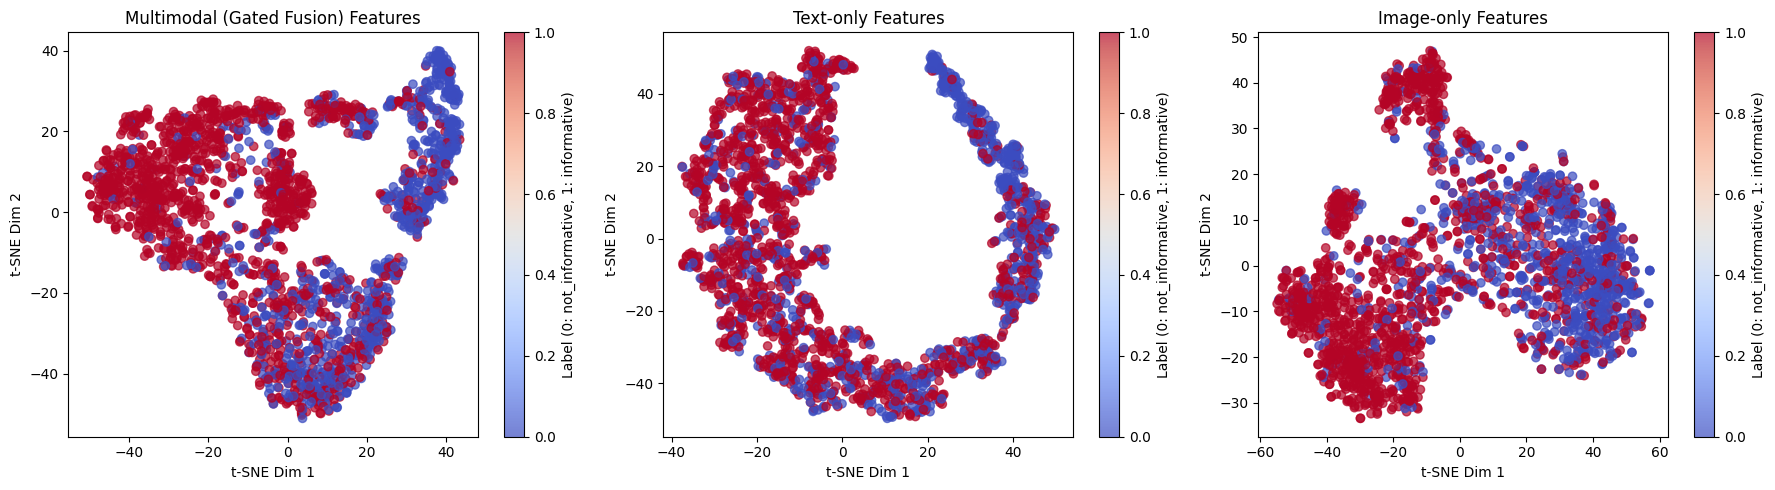

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def get_all_features(model, dataloader, device):
    """
    Extract features from the three branches:
    - Multimodal (gated fusion)
    - Text-only (BERT pooled output)
    - Image-only (ViT pooled output)
    Also returns the corresponding labels.
    """
    model.eval()
    all_mm_features = []
    all_text_features = []
    all_image_features = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # Text features from BERT
            text_outputs = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_embeds = text_outputs.pooler_output  # shape: (batch, hidden_size)
            
            # Image features from ViT
            image_outputs = model.image_encoder(pixel_values=images)
            image_embeds = image_outputs.pooler_output  # shape: (batch, hidden_size)
            
            # Multimodal features via gated fusion
            gate = torch.sigmoid(model.gate_layer(text_embeds + image_embeds))  # (batch, hidden_size)
            fused = gate * text_embeds + (1 - gate) * image_embeds  # (batch, hidden_size)
            
            all_mm_features.append(fused.cpu())
            all_text_features.append(text_embeds.cpu())
            all_image_features.append(image_embeds.cpu())
            # Use the multimodal label (or any of the provided labels)
            all_labels.append(batch['label'].cpu())
    
    mm_features = torch.cat(all_mm_features, dim=0)
    text_features = torch.cat(all_text_features, dim=0)
    image_features = torch.cat(all_image_features, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    return mm_features, text_features, image_features, labels

# Extract features from the dev/validation dataloader (or use train_loader as needed)
mm_features, text_features, image_features, labels = get_all_features(model, dev_loader, device)

# Now, use t-SNE to reduce each set of features to 2 dimensions.
# Note: We run t-SNE separately for each feature set.
tsne_mm = TSNE(n_components=2, random_state=42)
mm_features_2d = tsne_mm.fit_transform(mm_features.numpy())

tsne_text = TSNE(n_components=2, random_state=42)
text_features_2d = tsne_text.fit_transform(text_features.numpy())

tsne_image = TSNE(n_components=2, random_state=42)
image_features_2d = tsne_image.fit_transform(image_features.numpy())

# Plot the three t-SNE visualizations side-by-side.
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
scatter1 = plt.scatter(mm_features_2d[:, 0], mm_features_2d[:, 1],
                       c=labels.numpy(), cmap="coolwarm", alpha=0.7)
plt.title("Multimodal (Gated Fusion) Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter1, label="Label (0: not_informative, 1: informative)")

plt.subplot(1, 3, 2)
scatter2 = plt.scatter(text_features_2d[:, 0], text_features_2d[:, 1],
                       c=labels.numpy(), cmap="coolwarm", alpha=0.7)
plt.title("Text-only Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter2, label="Label (0: not_informative, 1: informative)")

plt.subplot(1, 3, 3)
scatter3 = plt.scatter(image_features_2d[:, 0], image_features_2d[:, 1],
                       c=labels.numpy(), cmap="coolwarm", alpha=0.7)
plt.title("Image-only Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter3, label="Label (0: not_informative, 1: informative)")

plt.tight_layout()
plt.show()


In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np

def evaluate_test(model, dataloader, device):
    """
    Evaluate the model on the test set and compute metrics for:
      - Multimodal (gated fusion) branch,
      - Text-only branch, and
      - Image-only branch.
    Returns a dictionary of metrics for each branch.
    """
    model.eval()
    mm_true, mm_preds = [], []
    text_true, text_preds = [], []
    image_true, image_preds = [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating on Test Set"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            
            # Forward pass through the model
            multimodal_logits, text_logits, image_logits = model(input_ids, attention_mask, images)
            
            # Get predictions by applying sigmoid and thresholding at 0.5
            mm_pred = (torch.sigmoid(multimodal_logits) > 0.5).cpu().numpy().astype(int).flatten()
            text_pred = (torch.sigmoid(text_logits) > 0.5).cpu().numpy().astype(int).flatten()
            image_pred = (torch.sigmoid(image_logits) > 0.5).cpu().numpy().astype(int).flatten()
            
            # Get true labels (for multimodal, text, and image respectively)
            mm_true_batch = batch['label'].cpu().numpy().astype(int).flatten()
            text_true_batch = batch['label_text'].cpu().numpy().astype(int).flatten()
            image_true_batch = batch['label_image'].cpu().numpy().astype(int).flatten()
            
            mm_preds.extend(mm_pred)
            mm_true.extend(mm_true_batch)
            
            text_preds.extend(text_pred)
            text_true.extend(text_true_batch)
            
            image_preds.extend(image_pred)
            image_true.extend(image_true_batch)
    
    # Compute metrics for each branch
    metrics = {}
    for branch, true_labels, preds in zip(["Multimodal", "Text-only", "Image-only"],
                                           [mm_true, text_true, image_true],
                                           [mm_preds, text_preds, image_preds]):
        acc = accuracy_score(true_labels, preds)
        prec = precision_score(true_labels, preds, pos_label=1)
        rec = recall_score(true_labels, preds, pos_label=1)
        f1 = f1_score(true_labels, preds, pos_label=1)
        metrics[branch] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1 Score": f1}
    
    return metrics

# Load test dataset from your test file path.
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_df = pd.read_csv(test_file_path, sep='\t')
test_dataset = CrisisDataset(test_df, tokenizer, image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate on the test set.
test_metrics = evaluate_test(model, test_loader, device)

# Print evaluation metrics for each branch.
for branch, m in test_metrics.items():
    print(f"\n{branch} Model Evaluation:")
    print(f"Accuracy:  {m['Accuracy']:.4f}")
    print(f"Precision: {m['Precision']:.4f}")
    print(f"Recall:    {m['Recall']:.4f}")
    print(f"F1 Score:  {m['F1 Score']:.4f}")


Evaluating on Test Set:   1%|          | 1/140 [00:05<13:44,  5.94s/it]c:\Users\Aman\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating on Test Set: 100%|██████████| 140/140 [04:24<00:00,  1.89s/it]


Multimodal Model Evaluation:
Accuracy:  0.7774
Precision: 0.8062
Recall:    0.8390
F1 Score:  0.8223

Text-only Model Evaluation:
Accuracy:  0.8288
Precision: 0.8435
Recall:    0.9361
F1 Score:  0.8874

Image-only Model Evaluation:
Accuracy:  0.8498
Precision: 0.8565
Recall:    0.8506
F1 Score:  0.8535
